Qustion4. Formulate and test a method to further improve the convergence rate of the Monte
Carlo approach.

—— Yuan Lu 14820609

In [12]:
max_iter = 1666 #The previously determined maximum number of iterations

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, MultiPolygon
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import Point
from shapely.ops import unary_union
import time
from scipy import stats

4.1 Adaptive Sampling

4.1.1 Initial sampling point

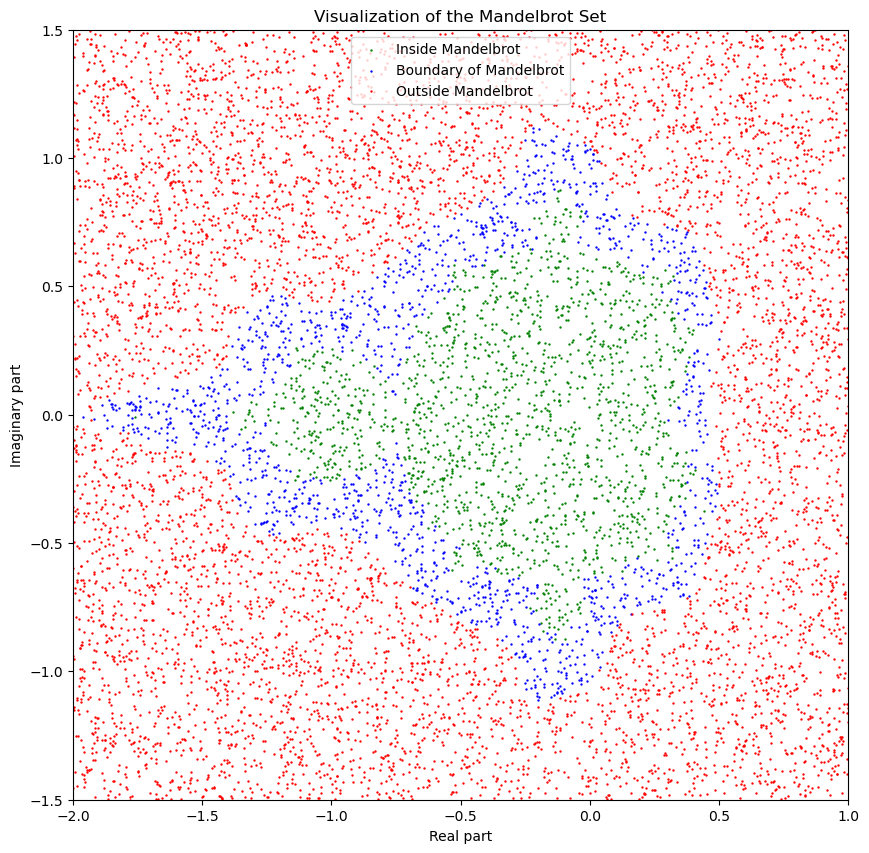

In [2]:

def mandelbrot(c, max_iter):
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

def random_sampling(x_range, y_range, num_samples):
    real = np.random.uniform(x_range[0], x_range[1], num_samples)
    imag = np.random.uniform(y_range[0], y_range[1], num_samples)
    return real + imag * 1j

def initial_sampling(x_range, y_range, num_samples, max_iter):
    points = random_sampling(x_range, y_range, num_samples)
    stabilities = [mandelbrot(c, max_iter) for c in points]
    inside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if  stability == max_iter]
    boundary_points = [points[i] for i, stability in enumerate(stabilities) if 5 < stability < max_iter]
    outside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability <= 5]
    return np.array(inside_mandelbrot),np.array(boundary_points),np.array(outside_mandelbrot)

x_range = [-2, 1]
y_range = [-1.5, 1.5]
num_samples = 10000

#Acquired boundary point
inside_mandelbrot, boundary_points , outside_mandelbrot= initial_sampling(x_range, y_range, num_samples, max_iter)

plt.figure(figsize=(10, 10))

# Plot each set of points with different colors
plt.scatter(inside_mandelbrot.real, inside_mandelbrot.imag, color='green', s=0.5, label='Inside Mandelbrot')
plt.scatter(boundary_points.real, boundary_points.imag, color='blue', s=0.5, label='Boundary of Mandelbrot')
plt.scatter(outside_mandelbrot.real, outside_mandelbrot.imag, color='red', s=0.5, label='Outside Mandelbrot')

plt.xlim(x_range)
plt.ylim(y_range)
plt.title('Visualization of the Mandelbrot Set')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.legend()
plt.show()


Generate three regions

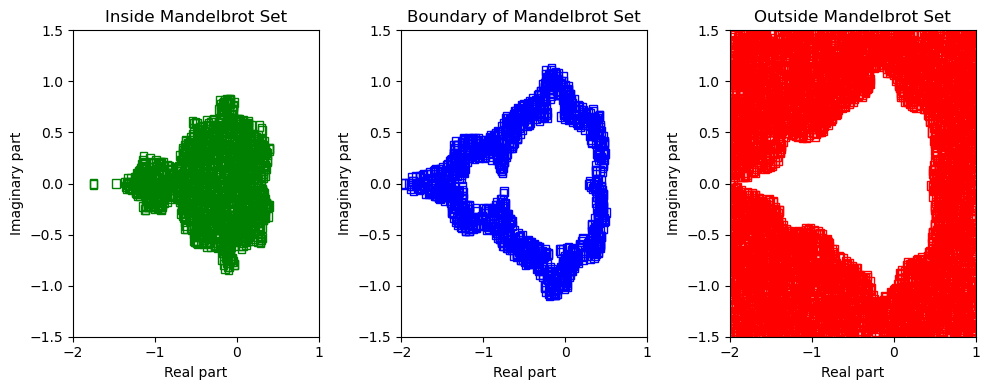

In [3]:
# Given an array of boundary points, and the size of the side length of the boundary region
def define_regions(points, side_length):
    squares = []
    half_side = side_length / 2

    for point in points:
        left = max(point.real - half_side, x_range[0])
        right = min(point.real + half_side, x_range[1])
        bottom = max(point.imag - half_side, y_range[0])
        top = min(point.imag + half_side, y_range[1])

        # Add only if the square is within the defined range
        if left < right and bottom < top:
            squares.append([left, right, bottom, top])

    return squares


init_area_of_sample = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
side_length = init_area_of_sample * 0.01
# Use examples
inside_mandelbrot, boundary_points , outside_mandelbrot = initial_sampling(x_range, y_range, num_samples, max_iter)

inside_mandelbrot_squares = define_regions(inside_mandelbrot, side_length)
boundary_squares = define_regions(boundary_points, side_length)  # 0.1 is the length of the side of the square area
outside_mandelbrot_squares = define_regions(outside_mandelbrot, side_length)

def visualize_regions(ax, squares, color, title):
    # Draw each square
    for square in squares:
        left, right, bottom, top = square
        square_patch = plt.Rectangle((left, bottom), right - left, top - bottom, 
                                     edgecolor=color, facecolor='none')
        ax.add_patch(square_patch)

    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.set_title(title)

# Create a 3x1 grid of plots
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Visualize each set of regions in separate subplots
visualize_regions(axs[0], inside_mandelbrot_squares, 'green', 'Inside Mandelbrot Set')
visualize_regions(axs[1], boundary_squares, 'blue', 'Boundary of Mandelbrot Set')
visualize_regions(axs[2], outside_mandelbrot_squares, 'red', 'Outside Mandelbrot Set')

plt.tight_layout()
plt.show()

merge regions

In [6]:
x_range = [-2, 1]
y_range = [-1.5, 1.5]

# Create a rectangular polygon
rectangle = box(x_range[0], y_range[0], x_range[1], y_range[1])

# Wrap the rectangular polygon in a MultiPolygon
init_space = MultiPolygon([rectangle])

def merge_squares(squares, current_sample_space=init_space):
    # Create polygons from the list of squares
    polygons = [Polygon([(left, bottom), (right, bottom), (right, top), (left, top)]) for left, right, bottom, top in squares]
    # Merge all polygons into a single shape
    merged_area = unary_union(polygons)

    # Use intersection method to get the intersection with current_sample_space
    intersection = merged_area.intersection(current_sample_space)

    # Return the intersection as a MultiPolygon
    if isinstance(intersection, MultiPolygon):
        return intersection
    elif isinstance(intersection, Polygon):
        return MultiPolygon([intersection])
    else:
        return MultiPolygon([])  # Return an empty MultiPolygon object
    
# Compute the merged areas for each set
inside_space = merge_squares(inside_mandelbrot_squares, init_space)
boundary_space = merge_squares(boundary_squares, init_space)
outside_space = merge_squares(outside_mandelbrot_squares, init_space)

print(f"Inside Mandelbrot Set Merged Area: {inside_space.area}")
print(f"Boundary of Mandelbrot Set Merged Area: {boundary_space.area}")
print(f"Outside Mandelbrot Set Merged Area: {outside_space.area}")

print(inside_space)
print(inside_space.area + boundary_space.area + outside_space.area)


Inside Mandelbrot Set Merged Area: 1.7892140787603448
Boundary of Mandelbrot Set Merged Area: 1.8369739655975441
Outside Mandelbrot Set Merged Area: 6.47517741270752
MULTIPOLYGON (((-1.2376951788030879 -0.157613311276516, -1.2574110947326047 -0.157613311276516, -1.2574110947326047 -0.1370482746633393, -1.2741618635772711 -0.1370482746633393, -1.2741618635772711 -0.1272094494335688, -1.2807425549714442 -0.1272094494335688, -1.2807425549714442 -0.0992966424358124, -1.334589885422706 -0.0992966424358124, -1.334589885422706 -0.0945870627846302, -1.386081524889515 -0.0945870627846302, -1.386081524889515 -0.0725830516767304, -1.405573260756553 -0.0725830516767304, -1.405573260756553 -0.0382369763168565, -1.4094950313803087 -0.0382369763168565, -1.4094950313803087 0.0517630236831435, -1.3767762128044563 0.0517630236831435, -1.3767762128044563 0.0943664201803412, -1.2867762128044564 0.0943664201803412, -1.2867762128044564 0.0910076452598601, -1.2867172802611657 0.0910076452598601, -1.286717280

Process the overlapping parts and supplement the unsampled parts

In [7]:
def adjust_spaces(inside_space, boundary_space, outside_space, init_space):
    # Step 1: Add intersection with boundary_space to boundary_space
    boundary_inside_intersection = boundary_space.intersection(inside_space)
    boundary_outside_intersection = boundary_space.intersection(outside_space)
    boundary_space = boundary_space.union(boundary_inside_intersection).union(boundary_outside_intersection)

    # Step 2: Remove intersection with boundary_space from inside_space and outside_space
    inside_space = inside_space.difference(boundary_inside_intersection)
    outside_space = outside_space.difference(boundary_outside_intersection)

    # Step 3: Add intersection between inside_space and outside_space to boundary_space
    inside_outside_intersection = inside_space.intersection(outside_space)
    boundary_space = boundary_space.union(inside_outside_intersection)

    # Remove intersections from inside_space and outside_space
    inside_space = inside_space.difference(inside_outside_intersection)
    outside_space = outside_space.difference(inside_outside_intersection)

    # Step 4: Calculate the difference between the union of all spaces and init_space
    union_of_spaces = inside_space.union(boundary_space).union(outside_space)
    difference = init_space.difference(union_of_spaces)
    #difference = union_of_spaces.difference(init_space)
    # Step 5: Add the difference to boundary_space
    boundary_space = boundary_space.union(difference)
    
    return inside_space, boundary_space, outside_space

# Adjust the spaces according to the rules
adjusted_inside_space, adjusted_boundary_space, adjusted_outside_space = adjust_spaces(inside_space, boundary_space, outside_space, init_space)

# Calculate the area of adjusted spaces
adjusted_inside_area = adjusted_inside_space.area
adjusted_boundary_area = adjusted_boundary_space.area
adjusted_outside_area = adjusted_outside_space.area

print(f"Adjusted Inside Mandelbrot Set Area: {adjusted_inside_area}")
print(f"Adjusted Boundary of Mandelbrot Set Area: {adjusted_boundary_area}")
print(f"Adjusted Outside Mandelbrot Set Area: {adjusted_outside_area}")

print(adjusted_inside_space)
print(adjusted_outside_space)
print(adjusted_inside_space.area+adjusted_boundary_space.area+adjusted_outside_space.area)


Adjusted Inside Mandelbrot Set Area: 1.2290711442730948
Adjusted Boundary of Mandelbrot Set Area: 1.8388300979277235
Adjusted Outside Mandelbrot Set Area: 5.932098757799187
MULTIPOLYGON (((0.3858694156623526 0.0701133964283441, 0.3579116696245208 0.0701133964283441, 0.3579116696245208 0.0698817480767545, 0.343236799170361 0.0698817480767545, 0.343236799170361 0.0680055093554831, 0.3256943661873874 0.0680055093554831, 0.3256943661873874 0.060582423940304, 0.2550207697548403 0.060582423940304, 0.2550207697548403 0.0344286331717874, 0.236840895714454 0.0344286331717874, 0.236840895714454 -0.0555713668282126, 0.2685211121266739 -0.0555713668282126, 0.2685211121266739 -0.0718918435764105, 0.2892582723136154 -0.0718918435764105, 0.2892582723136154 -0.0911665391848127, 0.3273535175845454 -0.0911665391848127, 0.3273535175845454 -0.1098713458167571, 0.3376004359782225 -0.1098713458167571, 0.3376004359782225 -0.1354872338671619, 0.3319448085342906 -0.1354872338671619, 0.3319448085342906 -0.22548

Visualize the results after the first round

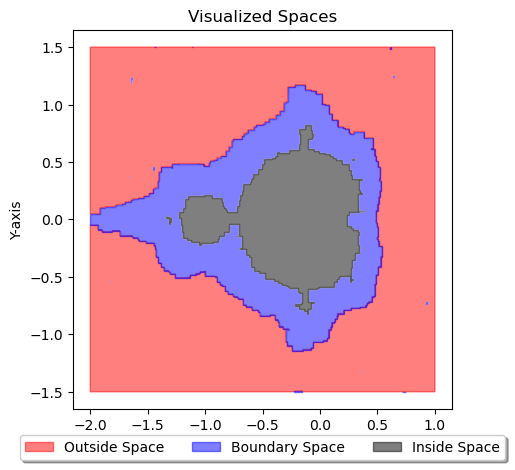

In [8]:
# Updated visualization function, allows specifying color
def visualize_space(merged_rectangles, ax, color='blue', label=''):
    # If it is a single Polygon, put it in a list
    if isinstance(merged_rectangles, Polygon):
        merged_rectangles = [merged_rectangles]
    # If it is a MultiPolygon, extract each Polygon
    elif isinstance(merged_rectangles, MultiPolygon):
        merged_rectangles = [polygon for polygon in merged_rectangles.geoms]

    # Draw and fill each polygon
    for polygon in merged_rectangles:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=0.5)  # Fill the exterior polygon
        # Draw inner polygons (holes)
        for interior in polygon.interiors:
            x, y = interior.xy
            ax.fill(x, y, color='white', alpha=1)  # Fill inner polygons with white to create hole effect
    ax.fill([], [], color=color, alpha=0.5, label=label)

# Create a new plot
fig, ax = plt.subplots()

# Visualize three areas with labels for the legend
visualize_space(adjusted_outside_space, ax, color='red', label='Outside Space')    # Outer space in red
visualize_space(adjusted_boundary_space, ax, color='blue', label='Boundary Space')  # Boundary space in blue
visualize_space(adjusted_inside_space, ax, color='black', label='Inside Space')     # Inner space in black

# Set the x and y boundaries of the image
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Visualized Spaces')
plt.gca().set_aspect('equal', adjustable='box')

# Add the legend to the plot
# Place the legend outside the plot area
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3)

# Adjust the layout to make room for the legend
plt.tight_layout()

# Display the plot
plt.show()


4.1.2 Improvements in sampling methods

In [9]:
def simplify_polygon(polygon, tolerance):
    """Simplify polygons using the Douglas-Peucker algorithm"""
    return polygon.simplify(tolerance, preserve_topology=True)

def random_sampling_within_multipolygon(multipolygon, num_samples, tolerance=0.01):
    # Determine whether it is a single polygon or multiple polygons and simplify it
    polygons = [simplify_polygon(multipolygon, tolerance)] if isinstance(multipolygon, Polygon) else [simplify_polygon(p, tolerance) for p in multipolygon.geoms]

    # Determine the number of samples for each subpolygon
    total_area = sum(p.area for p in polygons)
    sample_counts = [int(p.area / total_area * num_samples) for p in polygons]

    points = []
    for polygon, num_samples_in_polygon in zip(polygons, sample_counts):
        minx, miny, maxx, maxy = polygon.bounds
        samples_in_current_polygon = 0
        while samples_in_current_polygon < num_samples_in_polygon:
            real = np.random.uniform(minx, maxx)
            imag = np.random.uniform(miny, maxy)
            point = Point(real, imag)
            if polygon.contains(point):
                complex_point = real + imag * 1j
                points.append(complex_point)
                samples_in_current_polygon += 1
    return points


#Define sampling results
def random_sampling(multipolygon, num_samples, max_iter, iteration_threshold):
    points = random_sampling_within_multipolygon(multipolygon, num_samples)
    stabilities = [mandelbrot(c, max_iter) for c in points]
    inside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability == max_iter]
    boundary_points = [points[i] for i, stability in enumerate(stabilities) if iteration_threshold < stability < max_iter]
    outside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability <= iteration_threshold]
    return np.array(inside_mandelbrot), np.array(boundary_points), np.array(outside_mandelbrot)

4.1.3 Complete Adaptive sampling function

In [14]:
def mandelbrot(c, max_iter):
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

def init_sample_area(x_range,y_range):
    # Create a rectangular polygon
    rectangle = box(x_range[0], y_range[0], x_range[1], y_range[1])

    # Wrap the rectangular polygon in a MultiPolygon
    multipolygon = MultiPolygon([rectangle])
    return multipolygon

def simplify_polygon(polygon, tolerance):
    """Simplify polygons using the Douglas-Peucker algorithm"""
    return polygon.simplify(tolerance, preserve_topology=True)

def random_sampling_within_multipolygon(multipolygon, num_samples, tolerance=0.01):
    # Determine whether it is a single polygon or multiple polygons and simplify it
    polygons = [simplify_polygon(multipolygon, tolerance)] if isinstance(multipolygon, Polygon) else [simplify_polygon(p, tolerance) for p in multipolygon.geoms]

    # Determine the number of samples for each subpolygon
    total_area = sum(p.area for p in polygons)
    sample_counts = [int(p.area / total_area * num_samples) for p in polygons]

    points = []
    for polygon, num_samples_in_polygon in zip(polygons, sample_counts):
        minx, miny, maxx, maxy = polygon.bounds
        samples_in_current_polygon = 0
        while samples_in_current_polygon < num_samples_in_polygon:
            real = np.random.uniform(minx, maxx)
            imag = np.random.uniform(miny, maxy)
            point = Point(real, imag)
            if polygon.contains(point):
                complex_point = real + imag * 1j
                points.append(complex_point)
                samples_in_current_polygon += 1
    return points

#Define sampling results
def random_sampling(multipolygon, num_samples, max_iter, iteration_threshold):
    points = random_sampling_within_multipolygon(multipolygon, num_samples)
    stabilities = [mandelbrot(c, max_iter) for c in points]
    inside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability == max_iter]
    boundary_points = [points[i] for i, stability in enumerate(stabilities) if iteration_threshold < stability < max_iter]
    outside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability <= iteration_threshold]
    return np.array(inside_mandelbrot), np.array(boundary_points), np.array(outside_mandelbrot)

#Divide the sampling results into a collection of small squares
def define_regions(points, side_length):
    squares = []
    half_side = side_length / 2

    for point in points:
        left = max(point.real - half_side, x_range[0])
        right = min(point.real + half_side, x_range[1])
        bottom = max(point.imag - half_side, y_range[0])
        top = min(point.imag + half_side, y_range[1])

        # Add only if the square is within the defined range
        if left < right and bottom < top:
            squares.append([left, right, bottom, top])

    return squares

#Convert the collection of small squares to MultiPolygon format
def merge_squares(squares, current_sample_space):
    polygons = [Polygon([(left, bottom), (right, bottom), (right, top), (left, top)]) for left, right, bottom, top in squares]
    merged_area = unary_union(polygons)

    # Use the intersection method to obtain the intersection of the merged area and current_sample_space
    intersection = merged_area.intersection(current_sample_space)

    if isinstance(intersection, MultiPolygon):
        return intersection
    elif isinstance(intersection, Polygon):
        return MultiPolygon([intersection])
    else:
        return MultiPolygon([])  # Return an empty MultiPolygon object
    
#Process the three generated MultiPolygon areas
def adjust_spaces(inside_space, boundary_space, outside_space, init_space):
    # Step 1: Add intersection with boundary_space to boundary_space
    boundary_inside_intersection = boundary_space.intersection(inside_space)
    boundary_outside_intersection = boundary_space.intersection(outside_space)
    boundary_space = boundary_space.union(boundary_inside_intersection).union(boundary_outside_intersection)

    # Step 2: Remove intersection with boundary_space from inside_space and outside_space
    inside_space = inside_space.difference(boundary_inside_intersection)
    outside_space = outside_space.difference(boundary_outside_intersection)

    # Step 3: Add intersection between inside_space and outside_space to boundary_space
    inside_outside_intersection = inside_space.intersection(outside_space)
    boundary_space = boundary_space.union(inside_outside_intersection)

    # Remove intersections from inside_space and outside_space
    inside_space = inside_space.difference(inside_outside_intersection)
    outside_space = outside_space.difference(inside_outside_intersection)

    # Step 4: Calculate the difference between the union of all spaces and init_space
    union_of_spaces = inside_space.union(boundary_space).union(outside_space)
    difference = init_space.difference(union_of_spaces)

    # Step 5: Add the difference to boundary_space
    boundary_space = boundary_space.union(difference)
    return inside_space, boundary_space, outside_space

#Perform visual drawing of each round
def visualize_space(merged_rectangles, ax, color='blue', label=''):
    # If it is a single Polygon, put it into a list
    if isinstance(merged_rectangles, Polygon):
        merged_rectangles = [merged_rectangles]
    # If it is MultiPolygon, extract each Polygon
    elif isinstance(merged_rectangles, MultiPolygon):
        merged_rectangles = [polygon for polygon in merged_rectangles.geoms]

    # Draw and fill each polygon
    for polygon in merged_rectangles:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=0.5) # Fill the outer polygon
        # Draw internal polygons (holes)
        for interior in polygon.interiors:
            x, y = interior.xy
            ax.fill(x, y, color='white', alpha=1)  # Fill the inner polygons with white to create a hollow effect
    ax.fill([], [], color=color, alpha=0.5, label=label)
    
def add_area_text(fig, area, label, ypos):
    # Center the text horizontally at the given vertical position
    fig.text(0.5, ypos, f"{label}: {area:.2f}", ha='center', fontsize=9)
    
def final_sampling(multipolygon, num_samples, max_iter, iteration_threshold):
    points = random_sampling_within_multipolygon(multipolygon, num_samples)
    stabilities = [mandelbrot(c, max_iter) for c in points]

    # Count the number of points inside the Mandelbrot set
    count_inside_mandelbrot = sum(1 for stability in stabilities if stability == max_iter)

    # Calculate the probability of a point being inside the Mandelbrot set
    probability_inside_mandelbrot = count_inside_mandelbrot / num_samples
    last_area = probability_inside_mandelbrot * multipolygon.area
    return last_area


Run a complete simulation

circle 1
beta = 7
part0 code running time: 0.10765624046325684秒
part1 code running time: 0.2002880573272705秒
part2 code running time: 0.45042967796325684秒
Adjusted Inside Mandelbrot Set Area: 0.0
Adjusted Boundary of Mandelbrot Set Area: 8.24020715156402
Adjusted Outside Mandelbrot Set Area: 0.7597928484359815
Mandelbrot set 0.0


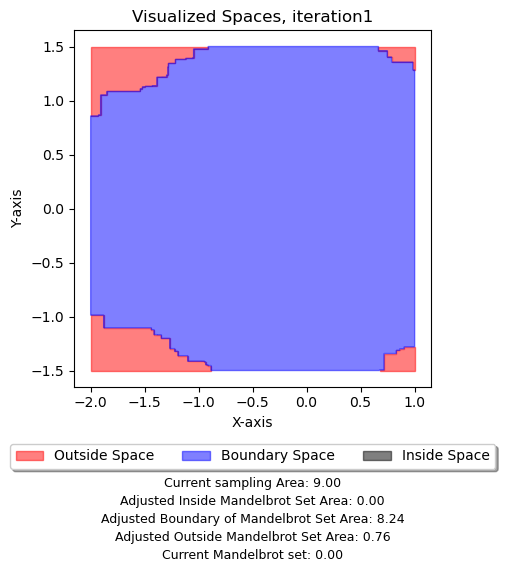

circle 2
beta = 7
part0 code running time: 0.15826010704040527秒
part1 code running time: 0.20787358283996582秒
part2 code running time: 0.7517588138580322秒
Adjusted Inside Mandelbrot Set Area: 0.0
Adjusted Boundary of Mandelbrot Set Area: 7.594310098140065
Adjusted Outside Mandelbrot Set Area: 0.645897053423953
Mandelbrot set 0.0


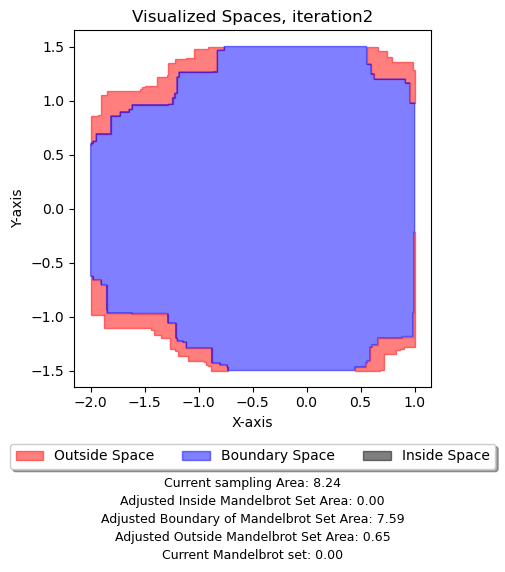

circle 3
beta = 7.700000000000001
part0 code running time: 0.19543147087097168秒
part1 code running time: 0.18032312393188477秒
part2 code running time: 0.13421916961669922秒
Adjusted Inside Mandelbrot Set Area: 0.0
Adjusted Boundary of Mandelbrot Set Area: 6.364913257363501
Adjusted Outside Mandelbrot Set Area: 1.229396840776571
Mandelbrot set 0.0


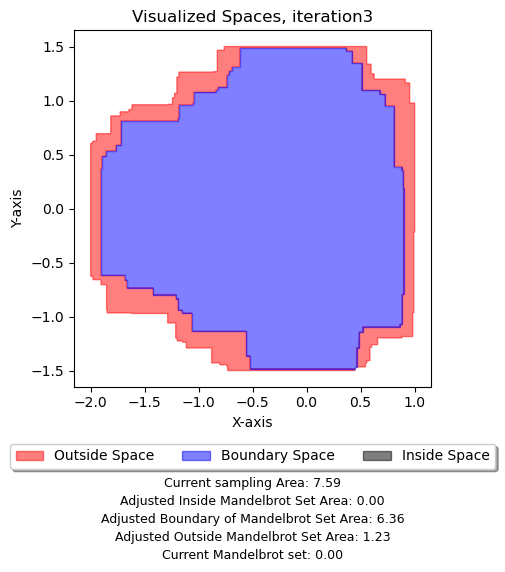

circle 4
beta = 8.470000000000002
part0 code running time: 0.24396681785583496秒
part1 code running time: 0.1304926872253418秒
part2 code running time: 0.006204366683959961秒
Adjusted Inside Mandelbrot Set Area: 0.06716486934449527
Adjusted Boundary of Mandelbrot Set Area: 4.8996984728835375
Adjusted Outside Mandelbrot Set Area: 1.398049915135465
Mandelbrot set 0.06716486934449527


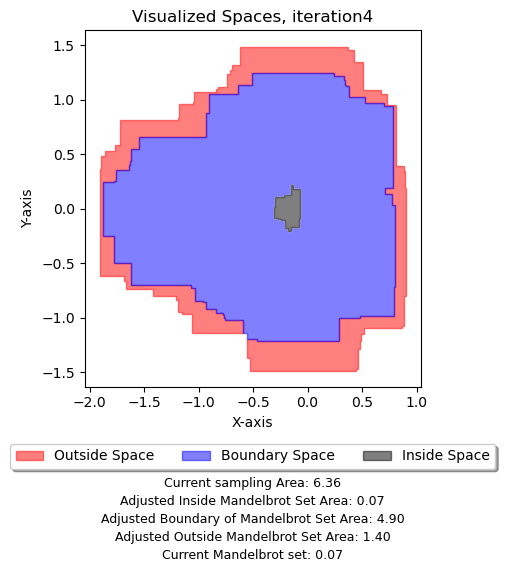

circle 5
beta = 9.317000000000004
part0 code running time: 0.27111053466796875秒
part1 code running time: 0.11157727241516113秒
part2 code running time: 0.00839543342590332秒
Adjusted Inside Mandelbrot Set Area: 0.22000034958214232
Adjusted Boundary of Mandelbrot Set Area: 3.493322128139443
Adjusted Outside Mandelbrot Set Area: 1.1863759951619561
Mandelbrot set 0.2871652189266376


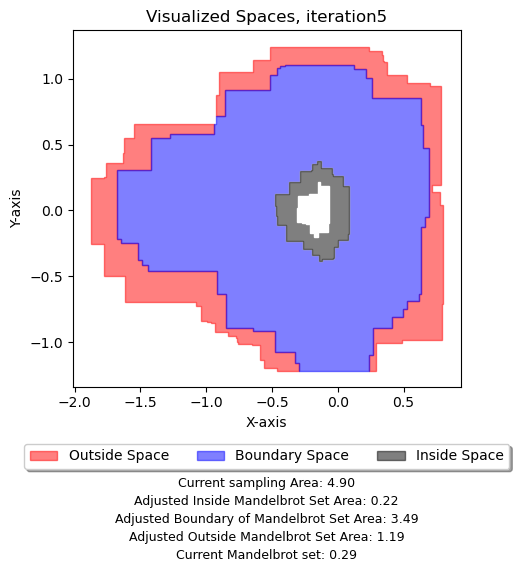

circle 6
beta = 10.248700000000005
part0 code running time: 0.35558605194091797秒
part1 code running time: 0.11084914207458496秒
part2 code running time: 0.017547130584716797秒
Adjusted Inside Mandelbrot Set Area: 0.2761616657733537
Adjusted Boundary of Mandelbrot Set Area: 2.3809669125343356
Adjusted Outside Mandelbrot Set Area: 0.8361935498317535
Mandelbrot set 0.5633268846999913


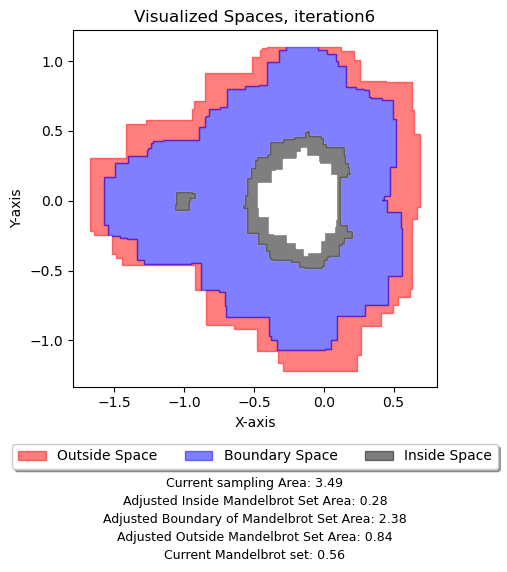

circle 7
beta = 11.273570000000007
part0 code running time: 0.44850683212280273秒
part1 code running time: 0.1249229907989502秒
part2 code running time: 0.039388418197631836秒
Adjusted Inside Mandelbrot Set Area: 0.28635452458725563
Adjusted Boundary of Mandelbrot Set Area: 1.532677020159864
Adjusted Outside Mandelbrot Set Area: 0.5619353677872146
Mandelbrot set 0.8496814092872469


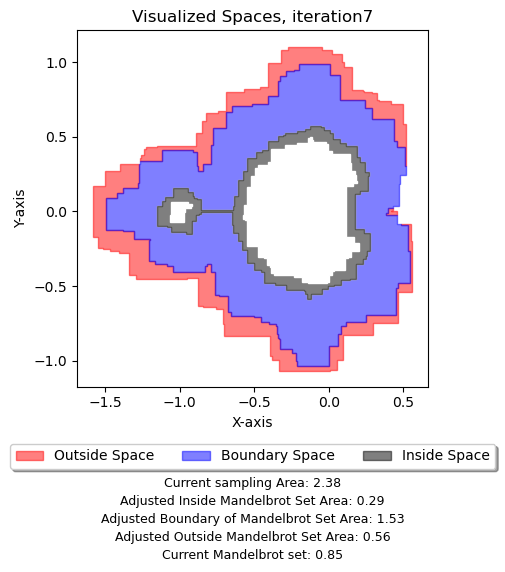

circle 8
beta = 12.400927000000008
part0 code running time: 0.6479053497314453秒
part1 code running time: 0.12881922721862793秒
part2 code running time: 0.04366612434387207秒
Adjusted Inside Mandelbrot Set Area: 0.2592255174822351
Adjusted Boundary of Mandelbrot Set Area: 0.9422830054758788
Adjusted Outside Mandelbrot Set Area: 0.33116849720175096
Mandelbrot set 1.108906926769482


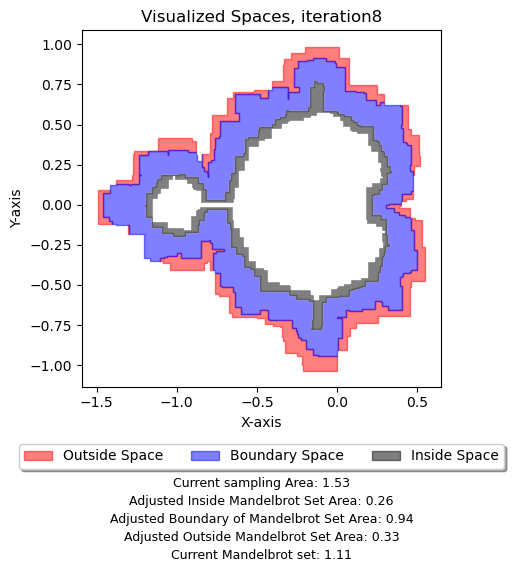

circle 9
beta = 11.160834300000008
part0 code running time: 1.0811407566070557秒
part1 code running time: 0.13716721534729004秒
part2 code running time: 0.07282447814941406秒
Adjusted Inside Mandelbrot Set Area: 0.11726236485153532
Adjusted Boundary of Mandelbrot Set Area: 0.6553319621449231
Adjusted Outside Mandelbrot Set Area: 0.16968867847942393
Mandelbrot set 1.2261692916210174


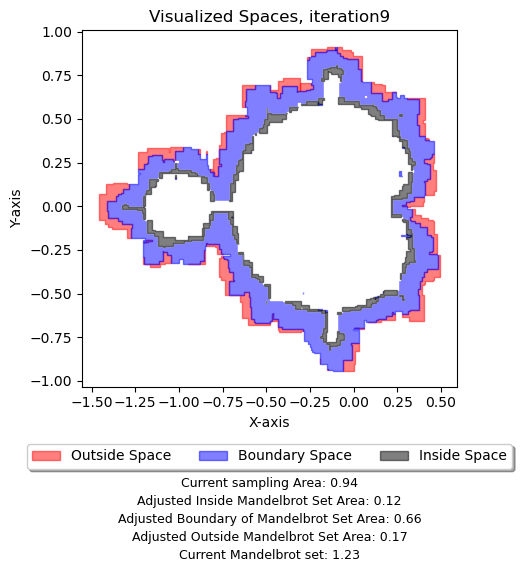

circle 10
beta = 12.27691773000001
part0 code running time: 1.7632205486297607秒
part1 code running time: 0.16469335556030273秒
part2 code running time: 0.10602593421936035秒
Adjusted Inside Mandelbrot Set Area: 0.11078803130633987
Adjusted Boundary of Mandelbrot Set Area: 0.40063709366758365
Adjusted Outside Mandelbrot Set Area: 0.14390683717099653
Mandelbrot set 1.3369573229273573


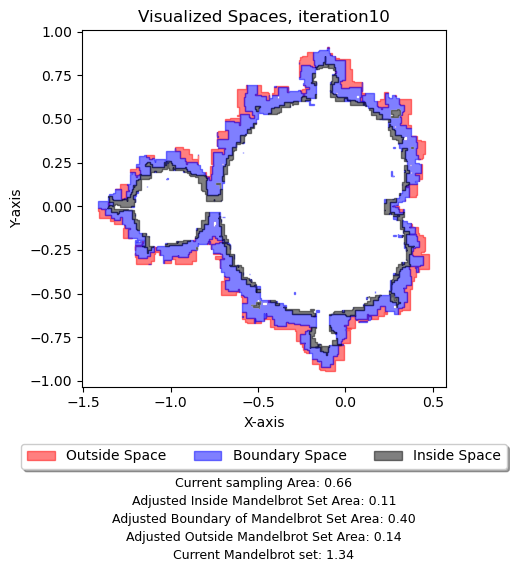

Mandelbrot set 1.5058058260535603


In [16]:
def main():
    x_range = [-2, 1]
    y_range = [-1.5, 1.5]
    num_samples = 2000
    init_area_of_sample = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    init_space = MultiPolygon([box(x_range[0], y_range[0], x_range[1], y_range[1])])


    sampletime = 10
    aim_samplesize = []
    true_samplesize = []
    inside = []
    outside = []
    boundary = []
    beta = 7
    last_sample = 1
    unknowarea = 0

    for i in range(sampletime):
        #Continuously update border areas
        if i == 0:
            current_sample_space = init_space
            current_area_size = init_area_of_sample
        else:
            current_sample_space = adjusted_boundary_space
            current_area_size = adjusted_boundary_space.area

        aim_samplesize.append(current_sample_space)
        iteration_threshold = (i + 1) * 5
        print(f"circle {i+1}")

        if i > 1 : 
            if adjusted_inside_space.area / current_area_size <= 0.2:
                beta *= 1.1
            else:
                beta *= 0.9
        print(f"beta = {beta}")
        side_length = current_area_size / beta

        

        start_time = time.time() 
        inside_mandelbrot, boundary_points , outside_mandelbrot= random_sampling(current_sample_space, 
                                                        num_samples, max_iter, iteration_threshold)

        end_time = time.time()  
        elapsed_time = end_time - start_time  

        print(f"part0 code running time: {elapsed_time}秒")#

        start_time = time.time() 

        inside_mandelbrot_squares = define_regions(inside_mandelbrot, side_length / 1.5)
        boundary_squares = define_regions(boundary_points, side_length)  # 0.1 is the length of the side of the square area
        outside_mandelbrot_squares = define_regions(outside_mandelbrot, side_length)

        inside_space = merge_squares(inside_mandelbrot_squares, current_sample_space)
        boundary_space = merge_squares(boundary_squares, current_sample_space)
        outside_space = merge_squares(outside_mandelbrot_squares, current_sample_space)
        

        end_time = time.time() 
        elapsed_time = end_time - start_time 

        print(f"part1 code running time: {elapsed_time}秒")


        start_time = time.time()  

        adjusted_inside_space, adjusted_boundary_space, adjusted_outside_space = adjust_spaces(inside_space,
                                                            boundary_space, outside_space, current_sample_space)
        
        
        end_time = time.time() 
        elapsed_time = end_time - start_time  

        print(f"part2 code running time: {elapsed_time}秒")
        
        inside.append(adjusted_inside_space.area)
        boundary.append(adjusted_boundary_space.area)
        outside.append(adjusted_outside_space.area)
        
        print(f"Adjusted Inside Mandelbrot Set Area: {adjusted_inside_space.area}")
        print(f"Adjusted Boundary of Mandelbrot Set Area: {adjusted_boundary_space.area}")
        print(f"Adjusted Outside Mandelbrot Set Area: {adjusted_outside_space.area}")

        exact_sample_area = adjusted_inside_space.area + adjusted_boundary_space.area + adjusted_outside_space.area
        true_samplesize.append(exact_sample_area)
        print(f"Mandelbrot set {sum(inside)}")

        
        # Create a new plot with adjusted margins
        fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the figsize as needed

        # Visualize three areas with labels for the legend
        visualize_space(adjusted_outside_space, ax, color='red', label='Outside Space')    # Outer space in red
        visualize_space(adjusted_boundary_space, ax, color='blue', label='Boundary Space')  # Boundary space in blue
        visualize_space(adjusted_inside_space, ax, color='black', label='Inside Space')     # Inner space in black

        # Set the x and y boundaries of the image
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title(f"Visualized Spaces, iteration{i+1}")
        plt.gca().set_aspect('equal', adjustable='box')

        # Adjust the layout to provide space at the bottom
        fig.tight_layout(rect=[0, 0.2, 1, 0.95])  # Modify the bottom value to accommodate text

        # Place the legend at the bottom center with a custom bounding box
        legend = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=3)

        # Adding area texts below the plot, above the legend placement
        add_area_text(fig, adjusted_inside_space.area + adjusted_boundary_space.area + adjusted_outside_space.area,
                    "Current sampling Area", 0.13)
        add_area_text(fig, adjusted_inside_space.area, "Adjusted Inside Mandelbrot Set Area", 0.10)
        add_area_text(fig, adjusted_boundary_space.area, "Adjusted Boundary of Mandelbrot Set Area", 0.07)
        add_area_text(fig, adjusted_outside_space.area, "Adjusted Outside Mandelbrot Set Area", 0.04)
        add_area_text(fig, sum(inside), "Current Mandelbrot set", 0.01)

        # Display the plot
        plt.show()
        
        if adjusted_boundary_space.area <= 0.001:
            last_sample = 1
            break
        unknowarea = adjusted_boundary_space
    if last_sample == 1:
        print(f"Mandelbrot set {sum(inside) + final_sampling(unknowarea, num_samples*10, max_iter, iteration_threshold)}")
    else:
        print(f"Mandelbrot set {sum(inside)}")
    return sum(inside)
main()

4.1.4 Adjust parameters to generate 30 simulation statistics

Remove all output parts in the main() function

In [26]:
def main():
    x_range = [-2, 1]
    y_range = [-1.5, 1.5]
    num_samples = 1000
    init_area_of_sample = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    init_space = MultiPolygon([box(x_range[0], y_range[0], x_range[1], y_range[1])])


    sampletime = 10
    aim_samplesize = []
    true_samplesize = []
    inside = []
    outside = []
    boundary = []
    beta = 7
    last_sample = 1
    unknowarea = 0

    for i in range(sampletime):
        #Continuously update border areas
        if i == 0:
            current_sample_space = init_space
            current_area_size = init_area_of_sample
        else:
            current_sample_space = adjusted_boundary_space
            current_area_size = adjusted_boundary_space.area

        aim_samplesize.append(current_sample_space)
        iteration_threshold = (i + 1) * 5
        #print(f"circle {i+1}")

        if i > 1 : 
            if adjusted_inside_space.area / current_area_size <= 0.2:
                beta *= 1.1
            else:
                beta *= 0.9
        #print(f"beta = {beta}")
        side_length = current_area_size / beta

        

        start_time = time.time() 
        inside_mandelbrot, boundary_points , outside_mandelbrot= random_sampling(current_sample_space, 
                                                        num_samples, max_iter, iteration_threshold)

        end_time = time.time()  
        elapsed_time = end_time - start_time  

        #print(f"part0 code running time: {elapsed_time}秒")#

        start_time = time.time() 

        inside_mandelbrot_squares = define_regions(inside_mandelbrot, side_length / 1.5)
        boundary_squares = define_regions(boundary_points, side_length)  # 0.1 is the length of the side of the square area
        outside_mandelbrot_squares = define_regions(outside_mandelbrot, side_length)

        inside_space = merge_squares(inside_mandelbrot_squares, current_sample_space)
        boundary_space = merge_squares(boundary_squares, current_sample_space)
        outside_space = merge_squares(outside_mandelbrot_squares, current_sample_space)
        

        end_time = time.time() 
        elapsed_time = end_time - start_time 

        #print(f"part1 code running time: {elapsed_time}秒")

        start_time = time.time()  

        adjusted_inside_space, adjusted_boundary_space, adjusted_outside_space = adjust_spaces(inside_space,
                                                            boundary_space, outside_space, current_sample_space)
        
        
        end_time = time.time() 
        elapsed_time = end_time - start_time  

        #print(f"part2 code running time: {elapsed_time}秒")
        
        inside.append(adjusted_inside_space.area)
        boundary.append(adjusted_boundary_space.area)
        outside.append(adjusted_outside_space.area)
        
        #print(f"Adjusted Inside Mandelbrot Set Area: {adjusted_inside_space.area}")
        #print(f"Adjusted Boundary of Mandelbrot Set Area: {adjusted_boundary_space.area}")
        #print(f"Adjusted Outside Mandelbrot Set Area: {adjusted_outside_space.area}")

        exact_sample_area = adjusted_inside_space.area + adjusted_boundary_space.area + adjusted_outside_space.area
        true_samplesize.append(exact_sample_area)
        #print(f"Mandelbrot set {sum(inside)}")

        
        # Create a new plot with adjusted margins
        #fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the figsize as needed

        # Visualize three areas with labels for the legend
        #visualize_space(adjusted_outside_space, ax, color='red', label='Outside Space')    # Outer space in red
        #visualize_space(adjusted_boundary_space, ax, color='blue', label='Boundary Space')  # Boundary space in blue
        #visualize_space(adjusted_inside_space, ax, color='black', label='Inside Space')     # Inner space in black

        # Set the x and y boundaries of the image
        #ax.set_xlabel('X-axis')
        #ax.set_ylabel('Y-axis')
        #ax.set_title(f"Visualized Spaces, iteration{i+1}")
        #plt.gca().set_aspect('equal', adjustable='box')

        # Adjust the layout to provide space at the bottom
        #fig.tight_layout(rect=[0, 0.2, 1, 0.95])  # Modify the bottom value to accommodate text

        # Place the legend at the bottom center with a custom bounding box
        #legend = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=3)

        # Adding area texts below the plot, above the legend placement
        #add_area_text(fig, adjusted_inside_space.area + adjusted_boundary_space.area + adjusted_outside_space.area,
        #            "Current sampling Area", 0.13)
        #add_area_text(fig, adjusted_inside_space.area, "Adjusted Inside Mandelbrot Set Area", 0.10)
        #add_area_text(fig, adjusted_boundary_space.area, "Adjusted Boundary of Mandelbrot Set Area", 0.07)
        #add_area_text(fig, adjusted_outside_space.area, "Adjusted Outside Mandelbrot Set Area", 0.04)
        #add_area_text(fig, sum(inside), "Current Mandelbrot set", 0.01)

        # Display the plot
        #plt.show()
        
        if adjusted_boundary_space.area <= 0.001:
            last_sample = 1
            break
        unknowarea = adjusted_boundary_space
    if last_sample == 1:
        print(f"Mandelbrot set {sum(inside) + final_sampling(unknowarea, num_samples*10, max_iter, iteration_threshold)}")
    else:
        print(f"Mandelbrot set {sum(inside)}")
    return sum(inside)

Calculate 99% confidence interval

In [29]:
def run_main_multiple_times(n=10):
    results = [main() for _ in range(n)]
    return results


# 运行 main 函数30次
results = run_main_multiple_times(30)


In [ ]:
def calculate_99_confidence_interval(data):
    mean = np.mean(data)
    std = np.std(data, ddof=1)  # 使用样本标准差
    se = std / np.sqrt(len(data))  # 计算标准误差
    interval = stats.norm.interval(0.99, loc=mean, scale=se)
    return interval
# 计算99%置信区间
confidence_interval = calculate_99_confidence_interval(results)
print("99% Confidence Interval:", confidence_interval)

0
99% Confidence Interval: (1.2985999882373338, 1.3212129883046015)
